In [43]:
import os
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

# Reproducibility (best-effort)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [44]:
# Custom Packages
from Packages.Imgprocessing import GrayscaleImageDataset
from Packages.discriminator import Discriminator  # preferred (Dicriminator alias also exists)
from Packages.generator import Generator

In [45]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [48]:
# Training config
DATA_DIR = "Faces_Dataset"  # folder that contains ONLY real face images (can include subfolders)

IMG_SIZE = 256
IN_CHANNELS = 1
Z_DIM = 128

BATCH_SIZE = 32

# IMPORTANT: Your dataset transform uses MTCNN on CUDA by default.
# CUDA + DataLoader multiprocessing (fork) will crash, so keep NUM_WORKERS=0 on GPU.
NUM_WORKERS = 0 if torch.cuda.is_available() else 2

LR = 2e-4
BETAS = (0.5, 0.999)

EPOCHS = 50
SAVE_EVERY_EPOCHS = 1
SAMPLE_EVERY_STEPS = 200  # save a grid every N steps

# Dataset normalization used inside GrayscaleImageDataset (see Packages/Imgprocessing.py)
DATASET_MEAN = 0.5
DATASET_STD = 0.225

RUN_DIR = Path("runs") / "gan_faces"
CKPT_DIR = RUN_DIR / "checkpoints"
SAMPLE_DIR = RUN_DIR / "samples"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset dir:", DATA_DIR)
print("Run dir:", RUN_DIR)
print("NUM_WORKERS:", NUM_WORKERS)

Dataset dir: Faces_Dataset
Run dir: runs/gan_faces
NUM_WORKERS: 0


In [49]:
# Dataset / DataLoader
dataset = GrayscaleImageDataset(DATA_DIR)
if len(dataset) == 0:
    raise RuntimeError(f"No images found under {DATA_DIR!r}. Put your real face images there (jpg/png/...).")

pin_memory = device.type == "cuda"
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
    persistent_workers=(NUM_WORKERS > 0),
    )

batch = next(iter(dataloader))
print("Number of images:", len(dataset))
print("Batch shape:", batch.shape, "dtype:", batch.dtype, "min/max:", float(batch.min()), float(batch.max()))

Number of images: 124771
Batch shape: torch.Size([32, 1, 256, 256]) dtype: torch.float32 min/max: -2.222222328186035 2.222222328186035


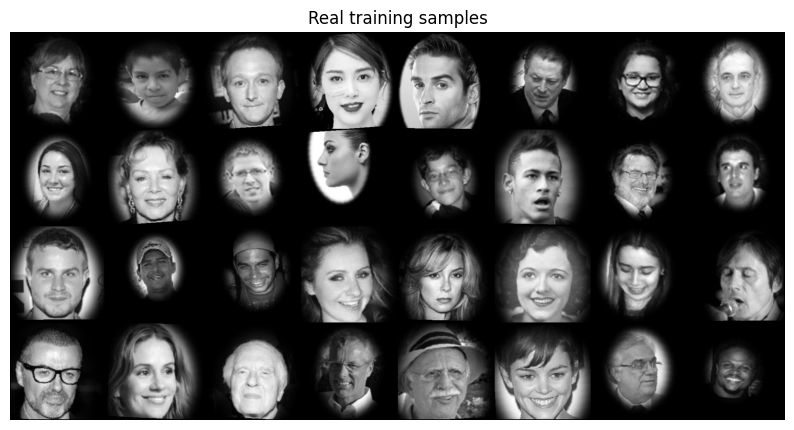

In [50]:
# Helpers: denorm + visualization/saving
def denorm(x: torch.Tensor, mean: float = DATASET_MEAN, std: float = DATASET_STD) -> torch.Tensor:
    """Convert dataset-normalized tensor back to [0,1]."""
    y = x * std + mean
    return y.clamp(0.0, 1.0)


@torch.no_grad()
def show_grid(x: torch.Tensor, title: str = "", nrow: int = 8, figsize=(10, 10)) -> None:
    x = x.detach().cpu()
    grid = make_grid(denorm(x), nrow=nrow)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).squeeze(-1), cmap="gray")
    plt.axis("off")
    plt.show()


@torch.no_grad()
def save_grid(x: torch.Tensor, path: Path, nrow: int = 8) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    # save_image expects [0,1]
    save_image(denorm(x).cpu(), str(path), nrow=nrow)


# Visualize a real batch
real_vis = batch[: min(32, batch.size(0))]
show_grid(real_vis, title="Real training samples")

In [51]:
# Models, loss, optimizers
D = Discriminator(in_channels=IN_CHANNELS).to(device)
G = Generator(
    z_dim=Z_DIM,
    out_channels=IN_CHANNELS,
    img_size=IMG_SIZE,
    output_mode="dataset",  # generate in SAME normalized space as the dataset
    dataset_mean=DATASET_MEAN,
    dataset_std=DATASET_STD,
).to(device)

criterion = nn.BCEWithLogitsLoss()
optD = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)
optG = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)

fixed_noise = torch.randn(64, Z_DIM, device=device)

# Quick sanity check
D.eval(); G.eval()
x_real = batch.to(device)
z = torch.randn(x_real.size(0), Z_DIM, device=device)
with torch.no_grad():
    x_fake = G(z)
    d_real = D(x_real)
    d_fake = D(x_fake)
print("D(real) shape:", tuple(d_real.shape), "D(fake) shape:", tuple(d_fake.shape))
print("Fake min/max (normalized space):", float(x_fake.min()), float(x_fake.max()))
G.train(); D.train()

D(real) shape: (32, 1, 1, 1) D(fake) shape: (32, 1, 1, 1)
Fake min/max (normalized space): -2.222221612930298 2.222222328186035


Discriminator(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Identity()
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): Identity()
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Identity()
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): Identity()
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (15): Identity()
    (16): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (conv_head): Conv2d(51

In [52]:
# Training loop (real-images-only GAN training)
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

global_step = 0
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    D.train(); G.train()
    if tqdm is None:
        loader = dataloader
    else:
        loader = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}")

    for real in loader:
        real = real.to(device, non_blocking=True)
        bsz = real.size(0)

        # --------------------
        # Train Discriminator
        # --------------------
        optD.zero_grad(set_to_none=True)

        # Real
        real_logits = D(real)
        real_targets = torch.ones_like(real_logits)
        lossD_real = criterion(real_logits, real_targets)

        # Fake (detach so G not updated here)
        z = torch.randn(bsz, Z_DIM, device=device)
        fake = G(z).detach()
        fake_logits = D(fake)
        fake_targets = torch.zeros_like(fake_logits)
        lossD_fake = criterion(fake_logits, fake_targets)

        lossD = (lossD_real + lossD_fake) / 2.0
        lossD.backward()
        optD.step()

        # --------------------
        # Train Generator
        # --------------------
        optG.zero_grad(set_to_none=True)
        z = torch.randn(bsz, Z_DIM, device=device)
        gen = G(z)
        gen_logits = D(gen)
        gen_targets = torch.ones_like(gen_logits)
        lossG = criterion(gen_logits, gen_targets)
        lossG.backward()
        optG.step()

        global_step += 1

        # Periodic sampling
        if SAMPLE_EVERY_STEPS and (global_step % SAMPLE_EVERY_STEPS == 0):
            G.eval()
            with torch.no_grad():
                samples = G(fixed_noise)
            sample_path = SAMPLE_DIR / f"step_{global_step:07d}.png"
            save_grid(samples, sample_path, nrow=8)
            if tqdm is None:
                print(f"Saved samples: {sample_path}")
            else:
                loader.set_postfix(lossD=float(lossD.item()), lossG=float(lossG.item()))
            G.train()

    # Save checkpoint + epoch samples
    if epoch % SAVE_EVERY_EPOCHS == 0:
        G.eval()
        with torch.no_grad():
            samples = G(fixed_noise)
        epoch_sample_path = SAMPLE_DIR / f"epoch_{epoch:04d}.png"
        save_grid(samples, epoch_sample_path, nrow=8)
        show_grid(samples[:32], title=f"Generated samples (epoch {epoch})", nrow=8)

        ckpt_path = CKPT_DIR / f"ckpt_epoch_{epoch:04d}.pt"
        torch.save(
            {
                "epoch": epoch,
                "global_step": global_step,
                "G": G.state_dict(),
                "D": D.state_dict(),
                "optG": optG.state_dict(),
                "optD": optD.state_dict(),
                "config": {
                    "DATA_DIR": DATA_DIR,
                    "IMG_SIZE": IMG_SIZE,
                    "IN_CHANNELS": IN_CHANNELS,
                    "Z_DIM": Z_DIM,
                    "BATCH_SIZE": BATCH_SIZE,
                    "LR": LR,
                    "BETAS": BETAS,
                    "DATASET_MEAN": DATASET_MEAN,
                    "DATASET_STD": DATASET_STD,
                },
            },
            str(ckpt_path),
        )
        print(f"Saved checkpoint: {ckpt_path}")
        G.train()

elapsed = time.time() - start_time
print(f"Training done. Steps={global_step}, elapsed={elapsed/60:.1f} min")

Epoch 1/50:   0%|          | 0/3899 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 646.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 67.88 MiB is free. Process 39152 has 92.00 MiB memory in use. Including non-PyTorch memory, this process has 3.50 GiB memory in use. Of the allocated memory 1.85 GiB is allocated by PyTorch, and 1.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Generate images from a saved checkpoint (optional)
# 1) Set CKPT_PATH to one of runs/gan_faces/checkpoints/*.pt
# 2) Run this cell to load + generate images

CKPT_PATH = None  # e.g. "runs/gan_faces/checkpoints/ckpt_epoch_0050.pt"

if CKPT_PATH:
    ckpt = torch.load(CKPT_PATH, map_location=device)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    G.eval(); D.eval()
    print("Loaded checkpoint epoch:", ckpt.get("epoch"))

    n = 64
    z = torch.randn(n, Z_DIM, device=device)
    with torch.no_grad():
        gen = G(z)
    out_path = SAMPLE_DIR / "generated_from_checkpoint.png"
    save_grid(gen, out_path, nrow=8)
    show_grid(gen[:32], title="Generated images")
    print("Saved:", out_path)
else:
    print("Set CKPT_PATH to load a checkpoint.")